In [1]:
from utils import set_root, PhysioLoader
import math
set_root()
%cd ..

Current working directory: /home/manni/physioex
/home/manni


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%ls

dreem/           miniconda3/  mne_data_old/  physioex/
lightning_logs/  mne_data/    models/        plots/


## Plotting Signals

In [3]:
# importing
from utils import PhysioLoader
import numpy as np
from loguru import logger
import os

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from typing import List

from loguru import logger

logger.remove()

In [4]:
models = ["seqsleepnet_cem"]
dataset = {"name": "sleep_merged", "version": "/"}
seqlen = 1
loss = "cel"
batch_size = 32

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
if dataset["name"] == "mitdb":
    sleep_stages = ["N", "S", "V", "F", "Q"]

labels_idx = np.arange(len(sleep_stages)).astype(int)
labels_idx_concept = np.arange(len(sleep_stages)).astype(int)

In [81]:
def plotTheSpectrogram(spectrogram_tensor):
    spectrogram_array = spectrogram_tensor.numpy()
    
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='viridis',vmin=-3, vmax=4)
    plt.colorbar(format='%+2.0f')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [82]:
import os
import re
import torch
from loguru import logger
import pytorch_lightning as pl
from physioex.train.networks.ae_fullyconnected import AutoEncoderFullyConnected
from physioex.train.networks.ae_conv3d import AutoEncoderConv3D
from physioex.train.networks.ae_seqsleepnet import AutoEncoderSeqSleepNet

# import importlib.util
# file_path = "physioex/physioex/train/networks/" + name + ".py"
# module_name = "AutoEncoderConv3D"
# spec = importlib.util.spec_from_file_location(module_name, file_path)
# module = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(module)
name = "ae_conv3d"
module = AutoEncoderConv3D

from physioex.data import TimeDistributedModule, datasets
from physioex.train.networks import config
from physioex.train.networks.utils.loss import config as loss_config

class PhysioLoader:
    def __init__(
        self,
        model_name: str = "chambon2018",
        dataset_name: str = "sleep_physionet",
        loss_name: str = "cel",
        ckp_path: str = None,
        version: str = "2018",
        picks: List[str] = ["EEG"],
        sequence_length: int = 1,
        batch_size: int = 32,
    ):
        if ckp_path is None:
            raise ValueError("ckp_path must be provided")
        if not os.path.isdir(ckp_path):
            raise ValueError(
                "ckp_path must be a valid directory containing at least one checkpoint"
            )

        self.model_name = model_name
        self.model_call = config[model_name]["module"]
        self.input_transform = config[model_name]["input_transform"]
        self.target_transform = None
        self.module_config = config[model_name]["module_config"]
        self.module_config["seq_len"] = sequence_length
        self.seq_len = sequence_length
        self.picks = picks
        #self.module_config["loss_call"] = loss_config[loss_name]
        #self.module_config["loss_params"] = dict()

        self.module_config["in_channels"] = len(picks)
        self.module_config["loss_call"] = loss_config[loss_name]

        self.batch_size = batch_size
        self.version = version

        logger.info("Scanning checkpoint directory...")
        self.checkpoints = {
            int(re.search(r"fold=(\d+)", elem.name).group(1)): elem.path
            for elem in os.scandir(ckp_path)
            if elem.is_file()
            and elem.name.endswith(".ckpt")
            and re.search(r"fold=(\d+)", elem.name)
        }

        logger.info(f"Found {len(self.checkpoints)} checkpoints")

        self.ckpt_path = ckp_path

        logger.info("Loading dataset")
        self.dataset_call = datasets[dataset_name]

        self.dataset = self.dataset_call(
            version=self.version,
            picks=picks,
            preprocessing=self.input_transform,
            sequence_length=self.seq_len,
            target_transform=None,
        )
        logger.info("Dataset loaded")

    def get_fold(self, fold: int = 0):

        logger.info(
            "JOB:%d-Splitting dataset into train, validation and test sets" % fold
        )
        self.dataset.split(fold)
        
        datamodule = TimeDistributedModule(
            dataset = self.dataset,
            batch_size = batch_size,
            fold = fold,
        )
        
        #self.module_config["loss_params"]["class_weights"] = datamodule.class_weights
        
    
        #model = self.model_call(module_config=self.module_config).load_from_checkpoint(
        model = module.load_from_checkpoint(
            self.checkpoints[fold], module_config=self.module_config
        ).eval()

        model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = model.to(model_device)
        train = datamodule.train_dataloader()
        test = datamodule.test_dataloader()
        valid = datamodule.val_dataloader()

        return model, train, valid, test


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/832 [00:00<?, ?it/s]

REM
tensor([[[ 0.0524, -0.2159, -0.3094,  ..., -0.5458, -0.5880, -1.3871],
         [ 0.0787,  0.4720, -0.0369,  ..., -1.1964, -0.4179, -1.4393],
         [ 0.5016,  0.1232, -0.0419,  ..., -1.5315, -2.2754, -1.1742],
         ...,
         [ 0.3640,  0.5528,  0.6382,  ..., -0.9737,  0.2016,  0.5737],
         [ 1.0989,  0.7006,  0.5668,  ...,  0.0792,  0.0831, -0.0708],
         [ 1.2176,  1.0198,  0.6430,  ...,  0.0281, -0.0451, -0.0439]]])
torch.Size([32, 3, 1, 29, 129])
shape x2plot:  torch.Size([3, 1, 29, 129])


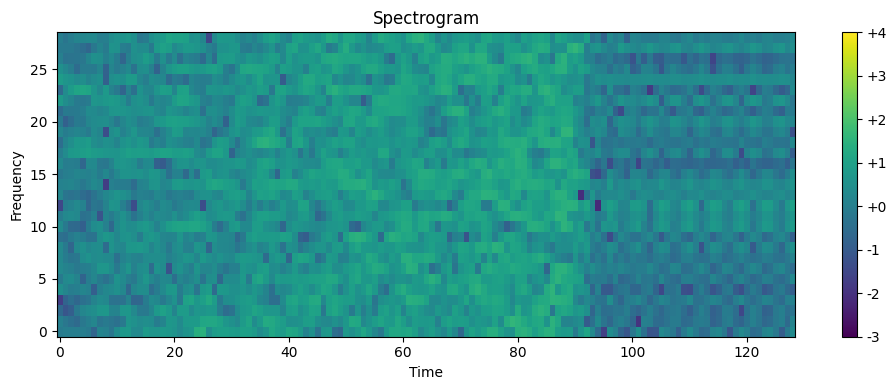

shape x_hat2plot:  torch.Size([3, 1, 29, 129])


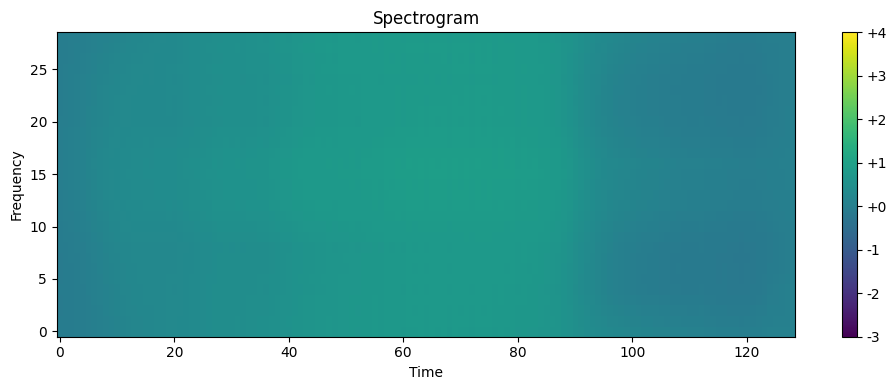

  0%|          | 0/832 [00:02<?, ?it/s]


In [94]:
ckp_path = "physioex/models/" + name +"/seqlen=3/merged/EEG"

loader = PhysioLoader(
    model_name=name,
    loss_name = "mse",
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    picks=["EEG"],
    sequence_length=3,
    batch_size=batch_size,
)

for i in range(len(loader.checkpoints)):
    model, _, _, test_loader = loader.get_fold(i)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Imposta il modello in modalità di valutazione
    model = model.eval().to(device)

    # Disabilita il calcolo del gradiente
    with torch.no_grad():
        # Aggiungi tqdm per mostrare il progresso
        
        for inputs, labels in tqdm(test_loader):
            indici = np.argwhere(labels.squeeze() == 4) # 0 per la classe awake, 1 per la classe N1 ecc
            indices_list = indici.tolist()[0] 
            if(len(indices_list) > 7):
                #print(indices_list)
                #print(labels.squeeze())
                # Calcola le previsioni del modello
                index = indices_list[3]
                print(sleep_stages[labels[index][0].item()]) #0 perchè prendo la prima epoca
                
                print(inputs[0][0])
                
                input_hat = model(inputs.to(device))
                print(input_hat.shape)
                #print(model.encode(inputs.to(device)).shape)
                
                x2plot = inputs[index]
                print("shape x2plot: ", x2plot.shape)
                plotTheSpectrogram(x2plot[0][0]) #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale 

                x_hat2plot = input_hat[index].to("cpu")
                print("shape x_hat2plot: ", x2plot.shape)
                plotTheSpectrogram(x_hat2plot[0][0]) #0 perchè prendo la prima epoca e il secondo 0 è per prendere il primo canale 
                break


## Extracting Loss Function Values


In [ ]:

import csv

def extract_column(csv_file, column_name):
    values = []
    steps = []
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row[column_name]:  # Check if the value in the specified column is not empty
                value = (round(float(row[column_name]), 3))
                epoch = int(row['epoch'])
                values.append((epoch, value))
    return values

# Example usage:
versions = [0,1,2,3,4,5,6,7,8,9]
column_name = 'val_loss_target'
model = 'binary_mod1_c8'
column_values_matrix = []
for ver in versions:
    csv_file = 'lightning_logs/' + model + '/version_'+ str(ver) +'/metrics.csv'
    column_values = extract_column(csv_file, column_name)
    print("(" + ")(".join([f"{epoch},{value}" for epoch, value in column_values]) + ")")
    column_values_matrix.append(column_values)

num_columns = len(column_values_matrix[0])
column_sums = [0] * num_columns
for row in column_values_matrix:
    for col_idx, (_, value) in enumerate(row):
        column_sums[col_idx] += value
column_means = [(constant[0], round(sum / len(column_values_matrix),3)) for constant, sum in zip(column_values_matrix[0][0:num_columns], column_sums)]

output = "(" + ")(".join([f"{epoch},{value}" for epoch, value in column_means]) + ")"
print("\n" +output)

(0,0.428)(1,0.347)(2,0.326)(3,0.337)(4,0.327)(5,0.335)(6,0.302)(7,0.32)(8,0.316)(9,0.335)(10,0.293)(11,0.324)(12,0.324)(13,0.318)(14,0.333)(15,0.316)(16,0.356)(17,0.376)(18,0.368)(19,0.395)
(0,0.266)(1,0.17)(2,0.166)(3,0.163)(4,0.156)(5,0.149)(6,0.153)(7,0.155)(8,0.156)(9,0.162)(10,0.163)(11,0.17)(12,0.209)(13,0.179)(14,0.234)(15,0.219)(16,0.193)(17,0.188)(18,0.22)(19,0.254)
(0,0.503)(1,0.372)(2,0.314)(3,0.314)(4,0.283)(5,0.261)(6,0.34)(7,0.286)(8,0.264)(9,0.254)(10,0.253)(11,0.335)(12,0.29)(13,0.308)(14,0.27)(15,0.294)(16,0.3)(17,0.311)(18,0.294)(19,0.3)
(0,0.319)(1,0.196)(2,0.174)(3,0.175)(4,0.172)(5,0.176)(6,0.178)(7,0.176)(8,0.179)(9,0.18)(10,0.177)(11,0.177)(12,0.181)(13,0.185)(14,0.201)(15,0.19)(16,0.208)(17,0.212)(18,0.24)(19,0.22)
(0,0.328)(1,0.179)(2,0.172)(3,0.183)(4,0.297)(5,0.18)(6,0.202)(7,0.206)(8,0.195)(9,0.218)(10,0.207)(11,0.202)(12,0.227)(13,0.215)(14,0.224)(15,0.231)(16,0.217)(17,0.282)(18,0.248)(19,0.218)
(0,0.27)(1,0.176)(2,0.168)(3,0.172)(4,0.171)(5,0.162)(6,0.169

In [ ]:
ckp_path = "models/ae"

loader = PhysioLoader(
    #model_name=model,
    #loss_name=loss,
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    use_cache=True,
    sequence_lenght=seqlen,
    batch_size=batch_size,
)

acc = []
acc_concept = []

cm = []
cm_concept = []

reports = []
reports_concept = []

for i in range(len(loader.checkpoints)):
    model, _, _, test_loader = loader.get_fold(i)
    y_pred = []
    y_true = []
    act_pred = []
    act_true = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Imposta il modello in modalità di valutazione
    model = model.eval().to(device)

    outputs = []
    activations = []
    # Disabilita il calcolo del gradiente
    with torch.no_grad():
        # Aggiungi tqdm per mostrare il progresso
        
        for inputs, labels in tqdm(test_loader):
            # Calcola le previsioni del modello
            print(inputs.shape)
            break
            concepts, bo = model.encode(inputs.to(device))
            emb, act = concepts
            activations.extend(act.cpu().detach().squeeze())

            outputs.extend(model(inputs.to(device)).cpu().detach())
            y_true.extend(labels.cpu().detach())
            act_true.extend(labels.cpu().detach())

    outputs = torch.stack(outputs)
    activations = torch.stack(activations)

    y_true = torch.stack(y_true)
    act_true = torch.stack(act_true)

    y_pred = torch.argmax(outputs, dim=len(outputs.size()) - 1)
    act_pred = torch.argmax(activations, dim=len(activations.size()) - 1)

    if len(y_pred.size()) == 2:
        y_pred = y_pred.reshape(-1)
        y_true = y_true.reshape(-1)
        act_pred = act_pred.reshape(-1)
        act_true = act_true.reshape(-1)

    y_true = y_true.numpy()
    act_true = act_true.numpy()
    y_pred = y_pred.numpy()
    act_pred = act_pred.numpy()

    #temp, finchè non ci sono le attivazioni vere
    if(model.n_classes == 2):
        #mette al posto di 2,3,4 il valore 1
        y_true[(y_true == 2) | (y_true == 3) | (y_true == 4)] = 1
        labels_idx = np.arange(2).astype(int)
    else:
        y_true = y_true
        
    print(y_true.shape, y_pred.shape, act_true.shape, act_pred.shape)

    acc.append(accuracy_score(y_true, y_pred))
    acc_concept.append(accuracy_score(act_true, act_pred))
    cm.append(confusion_matrix(y_true, y_pred, labels=labels_idx))
    cm_concept.append(confusion_matrix(act_true, act_pred, labels=labels_idx_concept))

    reports.append(classification_report(y_true, y_pred))
    reports_concept.append(classification_report(act_true, act_pred))

acc = np.array(acc)
cm = np.array(cm)

acc_concept = np.array(acc_concept)
cm_concept = np.array(cm_concept)

print(f"Accuracy: {acc.mean() * 100:.2f}% +/- {acc.std() * 100:.2f}%")
print(f"Accuracy concept: {acc_concept.mean() * 100:.2f}% +/- {acc_concept.std() * 100:.2f}%")

cm_mean = cm.mean(axis=0)
cm_mean = cm_mean.astype("float") / cm_mean.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
#plt.figure(figsize=(3.5, 3))
sns.heatmap(
    cm_mean,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    #xticklabels = ["Awake", "Sleep"],
    #yticklabels =  ["Awake", "Sleep"],
    xticklabels=sleep_stages,
    yticklabels=sleep_stages,
)
plt.title("Normalized Target Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

cm_concept_mean = cm_concept.mean(axis=0)
cm_concept_mean = cm_concept_mean.astype("float") / cm_concept_mean.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_concept_mean,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=sleep_stages,
    yticklabels=sleep_stages,
)
plt.title("Normalized Concept Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


